In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed, Conv1D, Input

import warnings
warnings.filterwarnings('ignore')

In [36]:
# importing data
data = pd.read_csv('Power_cs.csv')
data = data[data.timestamp.str.startswith('2008')]
data = data.set_index('timestamp')
data = data.replace('?', np.NaN).dropna()

In [38]:
for col in data.columns:
    data[col] = data[col].astype(float)

In [37]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2008-01-01 00:00:00,1.620,0.070,241.250,6.600,0.000,0.000,18.0
2008-01-01 00:30:00,1.652,0.100,241.140,6.800,0.000,0.000,18.0
2008-01-01 01:00:00,1.542,0.000,240.580,6.400,0.000,0.000,18.0
2008-01-01 01:30:00,1.542,0.000,240.630,6.400,0.000,0.000,18.0
2008-01-01 02:00:00,1.678,0.112,243.420,6.800,0.000,0.000,18.0
...,...,...,...,...,...,...,...
2008-12-31 21:30:00,1.932,0.106,242.700,8.000,0.000,0.000,0.0
2008-12-31 22:00:00,1.752,0.132,241.010,7.400,0.000,0.000,0.0
2008-12-31 22:30:00,0.580,0.074,246.600,2.600,0.000,0.000,0.0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17563 entries, 2008-01-01 00:00:00 to 2008-12-31 23:30:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    17563 non-null  float64
 1   Global_reactive_power  17563 non-null  float64
 2   Voltage                17563 non-null  float64
 3   Global_intensity       17563 non-null  float64
 4   Sub_metering_1         17563 non-null  float64
 5   Sub_metering_2         17563 non-null  float64
 6   Sub_metering_3         17563 non-null  float64
dtypes: float64(7)
memory usage: 1.7+ MB


In [41]:
'''for col in data.columns:
    fig,ax=plt.subplots(figsize=(20,3))
    sns.lineplot(data=data,x=data.index,y=col)'''

'for col in data.columns:\n    fig,ax=plt.subplots(figsize=(20,3))\n    sns.lineplot(data=data,x=data.index,y=col)'

In [42]:
ratio = 0.7

train_size = int(data.shape[0] * ratio)
train = data[:train_size]
test = data[train_size:]

dates_train = data.index[:train_size]
dates_test = data.index[train_size:]

In [46]:
#plots
'''fig,ax=plt.subplots(figsize=(20,3))
sns.lineplot(data=train,x=train.index,y='value')

fig,ax=plt.subplots(figsize=(20,3))
sns.lineplot(data=test,x=test.index,y='Global_active_power')'''

"fig,ax=plt.subplots(figsize=(20,3))\nsns.lineplot(data=train,x=train.index,y='value')\n\nfig,ax=plt.subplots(figsize=(20,3))\nsns.lineplot(data=test,x=test.index,y='Global_active_power')"

### Data standardization

In [48]:
scaler = StandardScaler()
scaler = scaler.fit(train.values)

In [49]:
def split_into_windows(X, length):
    windows = []
    for start in range(0, len(X) - length + 1):
        windows.append(X[start: start + length])
    return np.array(windows)

In [50]:
def process_data(df, scaler, lookback):
    
    scaled_input = scaler.transform(df)
    X = [] 

    for i in range(len(scaled_input) - lookback - 1):
        X.append([scaled_input[(i+j)] for j in range(0,lookback)])
        
    return np.array(X)

In [51]:
window_length = 48

X_train = process_data(train, scaler=scaler, lookback=window_length)
X_test = process_data(test, scaler=scaler, lookback=window_length)

#X_train = split_into_windows(train, window_length)
#X_test = split_into_windows(test, window_length)

_, input_length, input_dim = X_train.shape

In [52]:
X_train.shape

(12245, 48, 7)

In [53]:
# params
dim_hidden1 = 24 # 1/2 the length of one window
dim_hidden2 = 12 # 1/4 the length of one window


# model
model = Sequential()

model.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(1))

# summary
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 24)            3072      
_________________________________________________________________
dropout (Dropout)            (None, 48, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 12)            1776      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 12)            1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 24)            3

In [54]:
num_steps = X_train.shape[1]
num_features = X_train.shape[2]


# model
model = Sequential()

model.add(Input(shape=(num_steps, num_features)))

model.add(Conv1D(filters=32, kernel_size = 15, padding = 'same', data_format= 'channels_last',
                     dilation_rate = 1, activation = 'linear'))
model.add(LSTM(units = 24, activation = 'tanh',return_sequences= False))
model.add(RepeatVector(num_steps))

model.add(LSTM(units = 24, activation = 'tanh', return_sequences= True))
model.add(Conv1D(filters = 32, kernel_size = 15, padding = 'same', data_format = 'channels_last',
                     dilation_rate = 1, activation = 'linear'))
model.add(TimeDistributed(Dense(num_features, activation = 'linear')))


# summary
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 32)            3392      
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                5472      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 24)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 24)            4704      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 32)            11552     
_________________________________________________________________
time_distributed (TimeDistri (None, 48, 7)             231       
Total params: 25,351
Trainable params: 25,351
Non-trainable params: 0
__________________________________________________

### Fitting model

In [55]:
# params
batch_size = 48 # 24 hours == length of the window
epochs = 50
validation_split = 0.1

# fitting
history = model.fit(X_train, X_train, 
                batch_size = batch_size, 
                epochs = epochs, 
                validation_split = validation_split, 
                callbacks = [EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
230/230 [==============================] - 22s 74ms/step - loss: 0.9092 - val_loss: 0.5056
Epoch 2/50
230/230 [==============================] - 17s 73ms/step - loss: 0.8033 - val_loss: 0.4767
Epoch 3/50
230/230 [==============================] - 17s 76ms/step - loss: 0.7468 - val_loss: 0.4625
Epoch 4/50
230/230 [==============================] - 18s 77ms/step - loss: 0.7196 - val_loss: 0.4495
Epoch 5/50
230/230 [==============================] - 18s 78ms/step - loss: 0.6989 - val_loss: 0.4449
Epoch 6/50
230/230 [==============================] - 18s 77ms/step - loss: 0.6866 - val_loss: 0.4419
Epoch 7/50
230/230 [==============================] - 18s 77ms/step - loss: 0.6755 - val_loss: 0.4391
Epoch 8/50
230/230 [==============================] - 18s 80ms/step - loss: 0.6664 - val_loss: 0.4339
Epoch 9/50
230/230 [==============================] - 18s 77ms/step - loss: 0.6575 - val_loss: 0.4363
Epoch 10/50
230/230 [==============================] - 18s 77ms/step - loss: 0.651

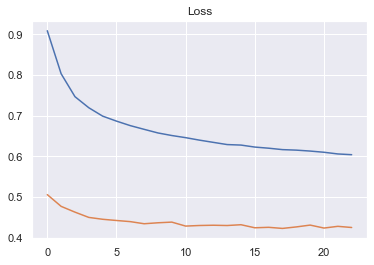

In [57]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

### Reconstruction

In [58]:
pred_x_test = model.predict(X_test)
pred_x_train = model.predict(X_train)

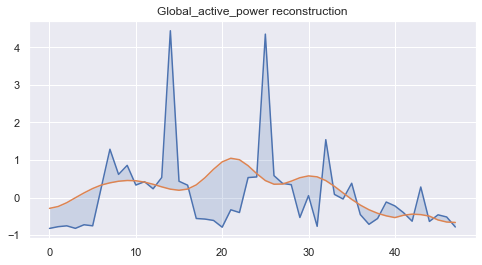

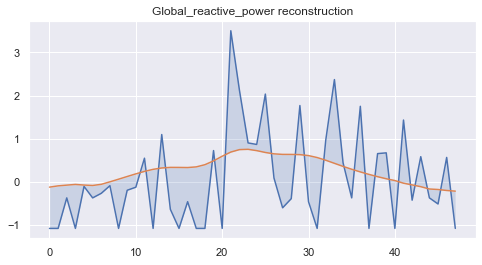

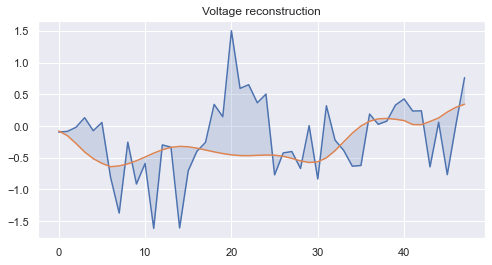

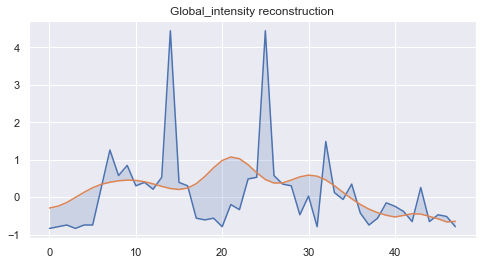

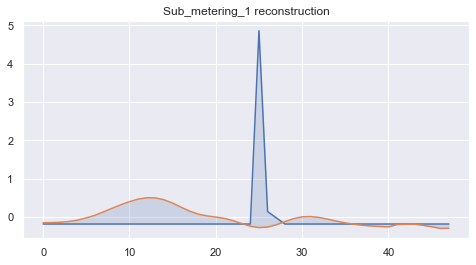

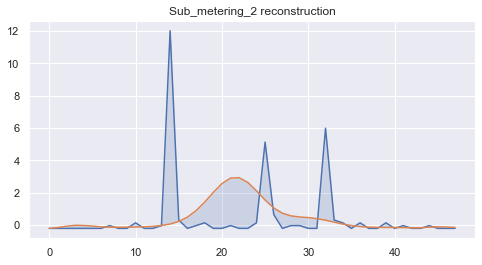

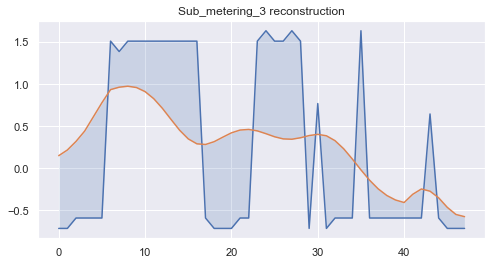

In [60]:
sel_period = 0

for num_var in range(num_features):
    
    X_test_var = X_test[:,:,num_var]
    pred_x_test_var = pred_x_test[:,:,num_var]

    x = X_test_var[sel_period * window_length].flatten()
    x_pred = pred_x_test_var[sel_period * window_length].flatten()
    
    fig,ax=plt.subplots(figsize=(8,4))
    plt.plot(x, label='x')
    plt.plot(x_pred, label='reconstruction')
    plt.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='error')
    plt.title('{} reconstruction'.format(test.columns[num_var]))

### MSE of the reconstruction

In [61]:
mse_train = pd.DataFrame(np.mean(np.abs(pred_x_train - X_train)**2, axis = 1),columns=['Error_{}'.format(s) for s in train.columns])
mse_test = pd.DataFrame(np.mean(np.abs(pred_x_test - X_test)**2, axis = 1),columns=['Error_{}'.format(s) for s in train.columns])

In [62]:
train_mae_loss = pd.DataFrame(mse_train.mean(axis=1), columns=['Error'])
test_mae_loss = pd.DataFrame(mse_test.mean(axis=1), columns=['Error'])

### Loss histrogram

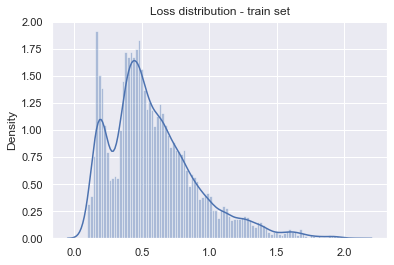

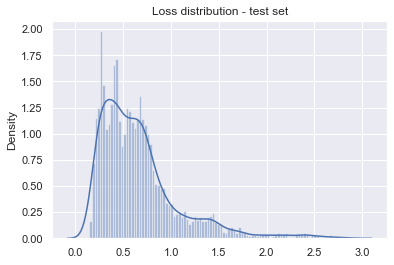

In [63]:
plt.title('Loss distribution - train set')
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

plt.title('Loss distribution - test set')
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

### Selection Threshold

threshold = mean of the loss + 2 standard devation of the loss

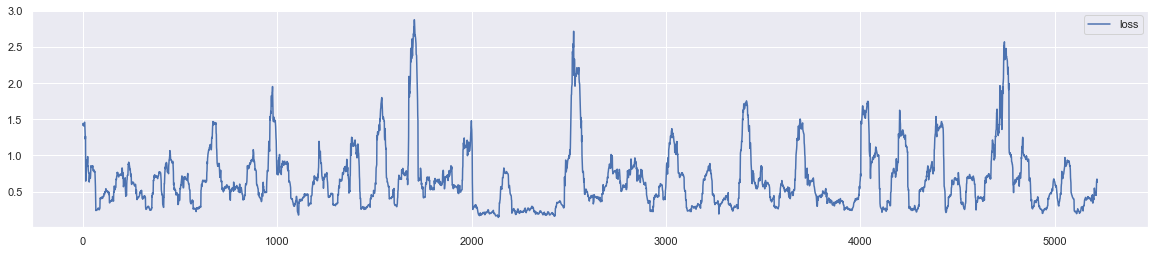

In [64]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.legend()
plt.show()

In [65]:
print(np.mean(test_mae_loss)[0] + 2 * np.std(test_mae_loss)[0])

1.5047446728644105


In [67]:
threshold = 1.5

### Loss for each window of the test set vs Threshold

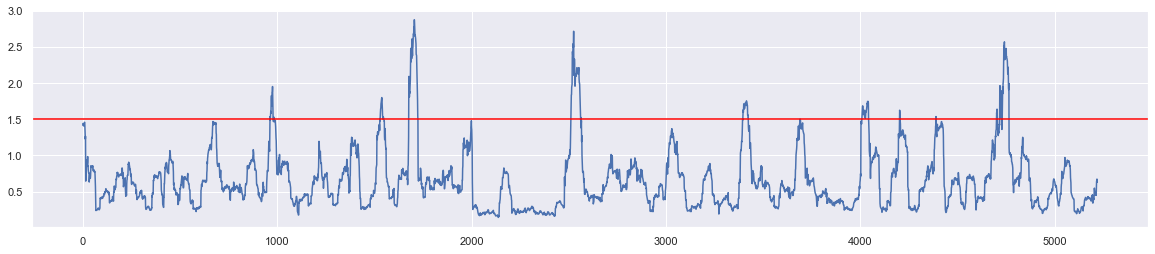

In [68]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.axhline(threshold, color='red', label='threshold')

### Dates where anomalies have been detected

In [71]:
y_pred = test_mae_loss_array >= threshold
y_pred.shape

(5220,)

In [72]:
dates_test[:-(window_length+1)].shape

(5220,)

In [75]:
dates_with_hours_anomalies = dates_test[:-(window_length+1)][y_pred]

In [88]:
test_anomaly = test.copy().reset_index()
test_anomaly['Fault'] = test_anomaly['timestamp'].apply(lambda x: 1 if x in dates_with_hours_anomalies else 0)

In [94]:
indexes = list(test_anomaly[test_anomaly.Fault == 1].index)

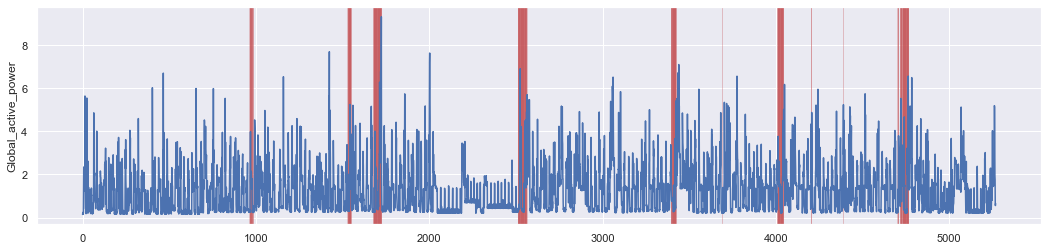

In [99]:
test_anomaly = test.copy().reset_index()

plt.figure(figsize=(18,4))
sns.lineplot(data=test_anomaly,x=test_anomaly.index,y='Global_active_power')
for index in indexes:
    plt.axvspan(index, index, color='r', alpha=0.3)